<a href="https://colab.research.google.com/github/irungus/Dessertation/blob/main/Species.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

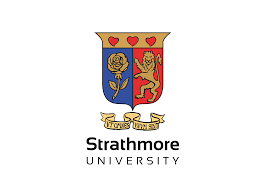

# Project Title

Optimizing agroforestry for climate resilience: A data-driven approach to mitigating environmental shocks and enhancing ecosystem stability

# Objective of the Study
The Objective is to develop machine learning models for optimizing agroforestry systems through species identification, classification, and Carbon sequestration valuation to enhance climate change mitigation and adaptation.

i.	Assess and quantify the potential for carbon sequestration within agroforestry systems using advanced ML techniques, supporting efforts to mitigate climate change.

ii.	To develop machine learning models for species identification and classification within agroforestry systems, enhancing biodiversity management.

iii. To develop a smart decision support system that combines ecological, climate, and species data, providing actionable recommendations in real time to farmers based on climate predictions, soil data, and agroforestry performance metrics.


# Introduction

We will first assess and quantify the potential for carbon sequestration within agroforestry systems using advanced ML techniques, supporting efforts to mitigate climate change. This will be done by calculating the Above Ground Biomass (AGB) using the data collected from the field and existing knowledge on how to calculate the AGB.

We are going to use traditional methods of calculating AGB famously know as Allometric equations and compare them with using various Machine Learning Algorithims. In short we will be comparing the allometric models to machine learning algorithms for aboveground biomass estimation in Agroforestry systems in Kenya

In [ ]:
#!pip install --upgrade scikit-learn

In [ ]:
#!pip install --upgrade scikit-learn xgboost

In [ ]:
#!pip install --upgrade xgboost

# Relevant Python Libraries

In [1]:
# Required packages
import pandas as pd  # Load and preprocess data.
import os  # Manage file paths and directories.
import requests  # Send HTTP requests to interact with web APIs or download content from the internet.
import io  # Provides tools for working with I/O streams.
import matplotlib.pyplot as plt  # Create static visualizations like line plots, bar charts, and scatter plots.
import seaborn as sns  # Create enhanced statistical data visualizations like heatmaps and pair plots.
import plotly.express as px  # Quickly create interactive visualizations like scatter plots, line charts, and maps.
import plotly.graph_objects as go  # Build detailed and customized interactive visualizations.
import numpy as np  # Perform numerical operations on arrays and matrices efficiently.
import math  # Perform basic mathematical calculations like logarithms and trigonometric functions.
import ee  # Use Google Earth Engine for large-scale geospatial analysis and satellite data processing.
import scipy.stats as stats  # Perform statistical functions and hypothesis testing.
from sklearn.preprocessing import StandardScaler  # Standardize features by removing the mean and scaling to unit variance.
from sklearn.model_selection import train_test_split  # Split data into training and testing sets for model evaluation.
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor  # Use ensemble methods for regression tasks.
from sklearn.neural_network import MLPRegressor  # Use a Multi-Layer Perceptron model for regression.
from sklearn.svm import SVR  # Use a Support Vector Regressor for regression problems.
from sklearn.metrics import mean_squared_error, r2_score  # Evaluate regression models using metrics like MSE and R².
from sklearn.model_selection import GridSearchCV
from xgboost.sklearn import XGBRegressor
import json

# Importing data from my Github



In [10]:
url = 'https://raw.githubusercontent.com/irungus/Dessertation/main/filtered_df.csv'
df = pd.read_csv(url, on_bad_lines='skip')

# Data Exploration

In [11]:
df.head()

,FID,start,end,Enumerator,agf,plotID,transect,County,localname,genus,...,canopyd,latitude,longitude,altitude,accuracy,__version_,_version_,key,KEY,date
0,6042,2024-12-07T15:47:34.780+03:00,,henry_oindi,pasture_agroforestry,31,2,Kwale,Hairy pod wattle,Acacia,...,450,-4.537429,39.139728,50.772,0.915,,,uuid:ad06a218-a495-4196-9d5a-abbd8b7f12cc,,2024-12-07
1,5988,2024-12-07T15:16:23.117+03:00,,david_makori,pasture_agroforestry,30,2,Kwale,Swamp mahogany,Eucalyptus,...,680,-4.522492,39.183680,-1.432,0.793,,,uuid:0530cc42-22ac-4dad-8f03-0951bd70fd2d,,2024-12-07
2,5985,2024-12-07T15:15:03.659+03:00,,david_makori,pasture_agroforestry,30,2,Kwale,Swamp mahogany,Eucalyptus,...,390,-4.522487,39.183677,-2.642,0.988,,,uuid:7df0b53b-3239-4ea4-9cf0-06de775914cc,,2024-12-07
3,5982,2024-12-07T15:12:19.093+03:00,,david_makori,pasture_agroforestry,30,2,Kwale,Swamp mahogany,Eucalyptus,...,390,-4.522480,39.183657,-1.658,0.882,,,uuid:15ef80e4-44ea-438f-98d4-d406ae20b2a0,,2024-12-07
4,5932,2024-12-07T14:25:22.771+03:00,,sarah_mwangi,pasture_agroforestry,29,2,Kwale,Murray redgum,Eucalyptus,...,430,-4.472281,39.189929,97.522,1.629,,,uuid:c05e61b3-3aa9-4c98-a139-1b6770bd9634,,2024-12-07


In [12]:
df['genus'].value_counts()

,count
genus,
Acacia,999
Grevillea,876
Eucalyptus,686
Musa,510


In [13]:
# Authenticate and initialize Google Earth Engine
ee.Authenticate()

True

In [14]:
ee.Initialize(project='agfkenya')

In [15]:
df.columns

Index(['FID', 'start', 'end', 'Enumerator', 'agf', 'plotID', 'transect',
       'County', 'localname', 'genus', 'species', 'newspecies', 'dbh',
       'height', 'canopyd', 'latitude', 'longitude', 'altitude', 'accuracy',
       '__version_', '_version_', 'key', 'KEY', 'date'],
      dtype='object')

In [16]:
def extract_sentinel_bands(latitude, longitude, accuracy):
    point = ee.Geometry.Point([longitude, latitude])
    buffer = point.buffer(accuracy)

    # Load Sentinel-2 and filter
    sentinel = ee.ImageCollection('COPERNICUS/S2_HARMONIZED') \
        .filterBounds(buffer) \
        .filterDate('2023-01-01', '2024-12-31') \
        .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 10)) \
        .select(['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B11', 'B12'])

    sentinel_mean = sentinel.mean()

    # Reduce region to get mean of bands
    band_values = sentinel_mean.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=buffer,
        scale=10
    )

    return band_values.getInfo()

In [17]:
def compute_indices(bands):
    try:
        B2 = bands.get('B2', None)
        B3 = bands.get('B3', None)
        B4 = bands.get('B4', None)
        B5 = bands.get('B5', None)
        B6 = bands.get('B6', None)
        B7 = bands.get('B7', None)
        B8 = bands.get('B8', None)
        B8A = bands.get('B8A', None)
        B11 = bands.get('B11', None)
        B12 = bands.get('B12', None)

        # Compute vegetation indices
        ndvi = (B8 - B4) / (B8 + B4) if B8 and B4 and (B8 + B4) != 0 else None
        evi = 2.5 * (B8 - B4) / (B8 + 6 * B4 - 7.5 * B2 + 1) if B8 and B4 and B2 and (B8 + 6 * B4 - 7.5 * B2 + 1) != 0 else None
        rep = B5 + ((B4 - B5) / (B6 - B5)) * (705 - 665) if B4 and B5 and B6 and (B6 - B5) != 0 else None
        swir = B11
        savi = ((B8 - B4) / (B8 + B4 + 0.5)) * 1.5 if B8 and B4 and (B8 + B4 + 0.5) != 0 else None
        lai = 3.618 * ((B8 - B4) / (B8 + B4) + 0.118) if B8 and B4 and (B8 + B4) != 0 else None

        return {
            'NDVI': ndvi,
            'EVI': evi,
            'REP': rep,
            'SWIR': swir,
            'SAVI': savi,
            'LAI': lai
        }
    except Exception as e:
        print("Error computing indices:", e)
        return {}


In [ ]:
# Collect results
all_results = []
for idx, row in df.iterrows():
    print(f"Processing point {idx + 1}/{len(df)}")
    try:
        bands = extract_sentinel_bands(row['latitude'], row['longitude'], accuracy=500)
        if bands:
            indices = compute_indices(bands)
            combined_result = {**bands, **indices}
            all_results.append(combined_result)
        else:
            all_results.append({})
    except Exception as e:
        print(f"Failed on row {idx}: {e}")
        all_results.append({})

# Merge back into original DataFrame
bands_indices_df = pd.DataFrame(all_results)
final_df = pd.concat([df.reset_index(drop=True), bands_indices_df.reset_index(drop=True)], axis=1)

# Save the enhanced CSV
final_df.to_csv('enhanced_with_bands_indices.csv', index=False)
print("✅ CSV created: enhanced_with_bands_indices.csv")

Processing point 1/3071
Processing point 2/3071
Processing point 3/3071
Processing point 4/3071
Processing point 5/3071
Processing point 6/3071
Processing point 7/3071
Processing point 8/3071
Processing point 9/3071
Processing point 10/3071
Processing point 11/3071
Processing point 12/3071
Processing point 13/3071
Processing point 14/3071
Processing point 15/3071
Processing point 16/3071
Processing point 17/3071
Processing point 18/3071
Processing point 19/3071
Processing point 20/3071
Processing point 21/3071
Processing point 22/3071
Processing point 23/3071
Processing point 24/3071
Processing point 25/3071
Processing point 26/3071
Processing point 27/3071
Processing point 28/3071
Processing point 29/3071
Processing point 30/3071
Processing point 31/3071
Processing point 32/3071
Processing point 33/3071
Processing point 34/3071
Processing point 35/3071
Processing point 36/3071
Processing point 37/3071
Processing point 38/3071
Processing point 39/3071
Processing point 40/3071
Processin

# Maachine Learning Models
## Random Forest


In [ ]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score

# Function to perform hyperparameter tuning using 5-fold cross-validation
def tune_random_forest(X_train, y_train):
    param_grid = {
        "n_estimators": [50, 100, 200],
        "max_depth": [None, 10, 20],
        "min_samples_split": [2, 5, 10],
        "min_samples_leaf": [1, 2, 4],
        "max_features": ["sqrt", "log2", 0.5],
        "bootstrap": [True]
    }

    grid_search = GridSearchCV(
        RandomForestRegressor(random_state=42, n_jobs=-1),
        param_grid,
        cv=5,
        scoring="neg_mean_squared_error",
        n_jobs=-1,
        verbose=1
    )

    grid_search.fit(X_train, y_train)
    return grid_search.best_estimator_, grid_search.best_params_

# Loop through each species and apply model
for species, group in acacia_df_cleaned_agb.groupby('genus_species'):
    X = group[['dbh', 'height_m']]
    y = group['AGB']

    # Split data into 80% training and 20% test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Tune and train Random Forest using the training dataset
    rf_model, rf_params = tune_random_forest(X_train, y_train)

    # 5-Fold Cross-Validation Evaluation (for stability)
    rmse_cv_scores = np.sqrt(-cross_val_score(rf_model, X_train, y_train, cv=5, scoring="neg_mean_squared_error"))
    r2_cv_scores = cross_val_score(rf_model, X_train, y_train, cv=5, scoring="r2")

    mean_rmse_cv = np.mean(rmse_cv_scores)
    mean_r2_cv = np.mean(r2_cv_scores)

    # Test Set Evaluation (for generalization)
    rf_preds_test = rf_model.predict(X_test)
    rmse_test = np.sqrt(mean_squared_error(y_test, rf_preds_test))
    r2_test = r2_score(y_test, rf_preds_test)

    # Print results
    print(f"Species: {species}")
    print(f" 5-Fold CV Mean RMSE: {mean_rmse_cv:.4f}")
    print(f" 5-Fold CV Mean R²: {mean_r2_cv:.4f}")
    print(f" Test Set RMSE: {rmse_test:.4f}")
    print(f" Test Set R²: {r2_test:.4f}")
    print(f"🏆 Best Hyperparameters: {rf_params}")
    print("-" * 50)

    # Store predictions safely
    acacia_df_cleaned_agb.loc[group.index, 'RF_Predicted_AGB'] = rf_model.predict(X)

print("5-fold cross-validation complete, predictions added.")


Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Species: Acacia drepanolobium
 5-Fold CV Mean RMSE: 180.5171
 5-Fold CV Mean R²: 0.5707
 Test Set RMSE: 48.0339
 Test Set R²: 0.9647
🏆 Best Hyperparameters: {'bootstrap': True, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
--------------------------------------------------
Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Species: Acacia mearnsii
 5-Fold CV Mean RMSE: 785.3072
 5-Fold CV Mean R²: 0.6645
 Test Set RMSE: 139.5979
 Test Set R²: 0.9845
🏆 Best Hyperparameters: {'bootstrap': True, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 50}
--------------------------------------------------
Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Species: Acacia mellifera
 5-Fold CV Mean RMSE: 452.2183
 5-Fold CV Mean R²: 0.6401
 Test Set RMSE: 108.5210
 Test Set R²: 0.7431
🏆 Best H

## Gradient Boosting (GB)

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Function to perform hyperparameter tuning with 5-fold cross-validation
def tune_gradient_boosting(X_train, y_train):
    param_grid = {
        "n_estimators": [100, 200],
        "learning_rate": [0.01, 0.1],
        "max_depth": [3, 5],
        "min_samples_split": [2, 5],
        "min_samples_leaf": [1, 2],
        "max_features": ["sqrt", "log2"],
        "subsample": [0.8, 1.0]
    }

    grid_search = GridSearchCV(
        GradientBoostingRegressor(random_state=42),
        param_grid,
        cv=5,  # 5-fold cross-validation
        scoring="neg_mean_squared_error",
        n_jobs=-1
    )

    grid_search.fit(X_train, y_train)
    return grid_search.best_estimator_, grid_search.best_params_

# Loop through each species
for species, group in acacia_df_cleaned_agb.groupby('genus_species'):
    X = group[['dbh', 'height_m']]
    y = group['AGB']

    # Split data into 80% training and 20% test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Tune and train Gradient Boosting using the training dataset
    gb_model, gb_params = tune_gradient_boosting(X_train, y_train)

    # Evaluate the model with 5-fold cross-validation using the training dataset
    rmse_scores = np.sqrt(-cross_val_score(gb_model, X_train, y_train, cv=5, scoring="neg_mean_squared_error"))
    r2_scores = cross_val_score(gb_model, X_train, y_train, cv=5, scoring="r2")

    # Compute mean RMSE and R² from cross-validation
    mean_rmse = np.mean(rmse_scores)
    mean_r2 = np.mean(r2_scores)

    # Compute metrics on the test set (for evaluation)
    gb_preds_test = gb_model.predict(X_test)
    rmse_test = np.sqrt(mean_squared_error(y_test, gb_preds_test))
    r2_test = r2_score(y_test, gb_preds_test)

    # Print mean RMSE, mean R², and best hyperparameters
    print(f"Species: {species}")
    print(f"Mean RMSE (5-Fold CV): {mean_rmse:.4f}")
    print(f"Mean R² (5-Fold CV): {mean_r2:.4f}")
    print(f"Test Set RMSE: {rmse_test:.4f}")
    print(f"Test Set R² : {r2_test:.4f}")
    print(f"Best Hyperparameters: {gb_params}")  # Print best hyperparameters
    print("-" * 50)

    # Make predictions for the entire group (using the trained model)
    gb_preds = gb_model.predict(X)  # Predict on the entire dataset (not just the test set)

    # Attach predictions to the original dataframe
    acacia_df_cleaned_agb.loc[group.index, 'GB_Predicted_AGB'] = gb_preds

print("5-fold cross-validation complete and predictions added.")

Species: Acacia drepanolobium
Mean RMSE (5-Fold CV): 143.4641
Mean R² (5-Fold CV): 0.7714
Test Set RMSE: 35.2110
Test Set R² : 0.9810
Best Hyperparameters: {'learning_rate': 0.1, 'max_depth': 3, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200, 'subsample': 0.8}
--------------------------------------------------
Species: Acacia mearnsii
Mean RMSE (5-Fold CV): 671.2635
Mean R² (5-Fold CV): 0.7773
Test Set RMSE: 73.3539
Test Set R² : 0.9957
Best Hyperparameters: {'learning_rate': 0.1, 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200, 'subsample': 0.8}
--------------------------------------------------
Species: Acacia mellifera
Mean RMSE (5-Fold CV): 364.0853
Mean R² (5-Fold CV): 0.7631
Test Set RMSE: 122.5123
Test Set R² : 0.6726
Best Hyperparameters: {'learning_rate': 0.1, 'max_depth': 3, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200, 'subsampl

## Extreme Gradient Boosting (XGB)<br>


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from xgboost import XGBRegressor
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.metrics import mean_squared_error, r2_score

# Custom wrapper for XGBRegressor to comply with Scikit-learn API
class SklearnCompatibleXGBRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, **kwargs):
        if "random_state" not in kwargs:
            kwargs["random_state"] = 42
        self.model = XGBRegressor(**kwargs)

    def fit(self, X, y):
        self.model.fit(X, y)
        return self

    def predict(self, X):
        return self.model.predict(X)

    def get_params(self, deep=True):
        return self.model.get_params(deep)

    def set_params(self, **params):
        self.model.set_params(**params)
        return self

# Function to perform hyperparameter tuning with 5-fold cross-validation
def tune_xgboost(X_train, y_train):
    param_grid = {
        "n_estimators": [100, 200],
        "learning_rate": [0.01, 0.1],
        "max_depth": [3, 5],
        "subsample": [0.8, 1.0],
        "colsample_bytree": [0.8, 1.0],
        "reg_alpha": [0, 0.1],
        "reg_lambda": [0, 0.1]
    }

    grid_search = GridSearchCV(
        SklearnCompatibleXGBRegressor(),
        param_grid,
        cv=5,
        scoring="neg_mean_squared_error",
        n_jobs=-1
    )

    grid_search.fit(X_train, y_train)
    return grid_search.best_estimator_, grid_search.best_params_


for species, group in acacia_df_cleaned_agb.groupby('genus_species'):
    X = group[['dbh', 'height_m']]
    y = group['AGB']

    # Split data into 80% training and 20% test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Tune and train XGBoost using the training dataset
    xgb_model, xgb_params = tune_xgboost(X_train, y_train)

    # Evaluate with 5-fold cross-validation using the training set
    rmse_scores = np.sqrt(-cross_val_score(xgb_model, X_train, y_train, cv=5, scoring="neg_mean_squared_error"))
    r2_scores = cross_val_score(xgb_model, X_train, y_train, cv=5, scoring="r2")

    # Compute mean RMSE and R²
    mean_rmse = np.mean(rmse_scores)
    mean_r2 = np.mean(r2_scores)

    # Compute test performance
    y_pred = xgb_model.predict(X_test)
    test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    test_r2 = r2_score(y_test, y_pred)

    # Print evaluation results
    print(f"Species: {species}")
    print(f"Mean RMSE (5-Fold CV): {mean_rmse:.4f}")
    print(f"Mean R² (5-Fold CV): {mean_r2:.4f}")
    print(f"Test RMSE: {test_rmse:.4f}")
    print(f"Test R² : {test_r2:.4f}")
    print(f"Best Hyperparameters: {xgb_params}")
    print("-" * 50)

    # Make predictions for the entire group and store in dataframe
    acacia_df_cleaned_agb.loc[group.index, 'AGB_XGBoost'] = xgb_model.predict(X)

print("5-fold cross-validation complete. Results displayed.")


Species: Acacia drepanolobium
Mean RMSE (5-Fold CV): 153.3978
Mean R² (5-Fold CV): 0.7784
Test RMSE: 39.9248
Test R² : 0.9756
Best Hyperparameters: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'reg_alpha': 0.1, 'reg_lambda': 0.1, 'subsample': 0.8}
--------------------------------------------------
Species: Acacia mearnsii
Mean RMSE (5-Fold CV): 648.1393
Mean R² (5-Fold CV): 0.8343
Test RMSE: 199.9691
Test R² : 0.9683
Best Hyperparameters: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'reg_alpha': 0, 'reg_lambda': 0.1, 'subsample': 0.8}
--------------------------------------------------
Species: Acacia mellifera
Mean RMSE (5-Fold CV): 325.4944
Mean R² (5-Fold CV): 0.8057
Test RMSE: 97.1366
Test R² : 0.7942
Best Hyperparameters: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'reg_alpha': 0, 'reg_lambda': 0, 'subsample': 0.8}
------------------------------------------------

## Support Vector Machine <br>

New code

In [ ]:
import numpy as np
import pandas as pd
import json
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score

# Function to perform hyperparameter tuning with 5-fold cross-validation
def tune_svm(X_train, y_train):
    param_grid = {
        "C": [0.1, 1, 10],
        "epsilon": [0.01, 0.1, 0.2, 0.5, 1],
        "kernel": ["linear", "rbf"]
    }

    grid_search = GridSearchCV(
        SVR(),
        param_grid,
        cv=5,
        scoring="neg_mean_squared_error",
        n_jobs=-1
    )

    grid_search.fit(X_train, y_train)
    return grid_search.best_estimator_, grid_search.best_params_

# Loop through each species
for species, group in acacia_df_cleaned_agb.groupby('genus_species'):
    X = group[['dbh', 'height_m']]
    y = group['AGB']

    # Split into 80% train and 20% test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Tune and train SVM using the training dataset
    svm_model, svm_params = tune_svm(X_train, y_train)

    # Evaluate with 5-fold cross-validation
    rmse_scores = np.sqrt(-cross_val_score(svm_model, X_train, y_train, cv=5, scoring="neg_mean_squared_error"))
    r2_scores = cross_val_score(svm_model, X_train, y_train, cv=5, scoring="r2")

    # Compute mean RMSE and R²
    mean_rmse = np.mean(rmse_scores)
    mean_r2 = np.mean(r2_scores)

    # Predict on the test set
    y_pred_test = svm_model.predict(X_test)
    test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
    test_r2 = r2_score(y_test, y_pred_test)

    # Print evaluation results
    print(f"Species: {species}")
    print(f"Mean RMSE (5-Fold CV): {mean_rmse:.4f}")
    print(f"Mean R² (5-Fold CV): {mean_r2:.4f}")
    print(f"Test RMSE: {test_rmse:.4f}")
    print(f"Test R²: {test_r2:.4f}")
    print(f"Best Hyperparameters: {svm_params}")
    print("-" * 50)

    # Store predictions in the dataframe
    acacia_df_cleaned_agb.loc[group.index, 'AGB_SVM'] = svm_model.predict(X)

print("5-fold cross-validation complete. Results displayed.")



Species: Acacia drepanolobium
Mean RMSE (5-Fold CV): 215.7396
Mean R² (5-Fold CV): 0.6200
Test RMSE: 111.8357
Test R²: 0.8087
Best Hyperparameters: {'C': 10, 'epsilon': 0.01, 'kernel': 'linear'}
--------------------------------------------------
Species: Acacia mearnsii
Mean RMSE (5-Fold CV): 849.2291
Mean R² (5-Fold CV): 0.6805
Test RMSE: 466.8515
Test R²: 0.8272
Best Hyperparameters: {'C': 10, 'epsilon': 0.5, 'kernel': 'linear'}
--------------------------------------------------
Species: Acacia mellifera
Mean RMSE (5-Fold CV): 344.9899
Mean R² (5-Fold CV): 0.7721
Test RMSE: 225.4818
Test R²: -0.1092
Best Hyperparameters: {'C': 10, 'epsilon': 0.2, 'kernel': 'linear'}
--------------------------------------------------
Species: Acacia nilotica
Mean RMSE (5-Fold CV): 588.3868
Mean R² (5-Fold CV): 0.5469
Test RMSE: 81.3010
Test R²: 0.7909
Best Hyperparameters: {'C': 10, 'epsilon': 0.2, 'kernel': 'linear'}
--------------------------------------------------
Species: Acacia tortilis
Mean RMS

#Extraction of features from remote sensing imagery